In [1]:
import numpy as np

#
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import colors
from matplotlib import cm
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import matplotlib
matplotlib.rcParams['agg.path.chunksize'] = 10000

from scipy.interpolate import interpn
import math
import warnings
%matplotlib inline
import xarray as xr
#import bisect

warnings.filterwarnings('ignore')

# on the header:
import matplotlib as mpl
import math
import pandas as pd

In [2]:
ds = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_flt.nc')
ds1 = xr.open_dataset('/scratch/project_2000789/muramarg/waom_yearly_floats/output_WAOM_check/ocean_avg_0001.nc')
dg = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10_frc/waom10extend_grd.nc')

### Plot depth with time, color by rate of change of T on the trajectory

In [3]:
# retrieve the AABW indexes
with open("/scratch/project_2000789/muramarg/SOM/AABW_idxs.txt","r") as g:
    aabw_idx = g.read().splitlines() 
    aabw_idx = [int(x) for x in aabw_idx]
len(aabw_idx)

349

In [4]:
depth = ds.variables['depth'].values[:,aabw_idx]
temp = ds.variables['temp'].values[:,aabw_idx]

In [5]:
time = temp.shape[0]
time = np.arange(0,time,1)
x_time = np.tile(time,(349,1))
x_time = x_time.T   # this will be our time matrix to color the numbers
x_time = x_time*900/86400

In [6]:
# mark the first values in each column
first_depths = np.array([])
first_times = np.array([])
a = depth[:,0]
b = a[~np.isnan(a)]
print(len(a),a)
print(len(b),b)
print(a[len(a)-len(b)-1])   # this is the first non nan value, the index is len(a)-len(b)

for idx in (range(depth.shape[1])):
    a = depth[:,idx]
    b = a[~np.isnan(a)]
    first_depths = np.append(first_depths,b[0])
    first_times = np.append(first_times,(len(a)-len(b))*900/86400)

65717 [       nan        nan        nan ... -2580.5686 -2580.5654 -2580.543 ]
55636 [   -2.6838193    -2.7034667    -2.7250388 ... -2580.5686    -2580.5654
 -2580.543    ]
nan


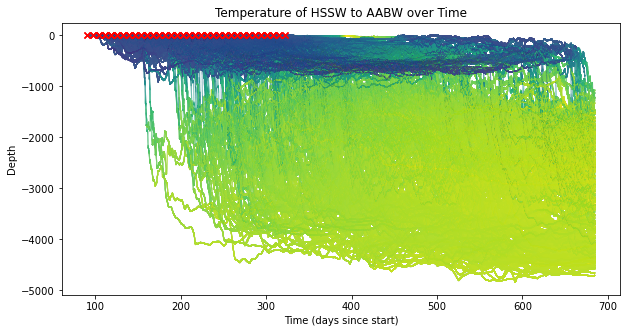

In [7]:
# plot particles with y=depth, x=time, color=temp
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
                 
plt.scatter(x_time,depth,marker=".",s=0.05,c=temp)
plt.scatter(first_times,first_depths,marker='x',c="red",label="Start Point")
plt.title("Temperature of HSSW to AABW over Time")

# plt.plot(salt_flat,temp_flat,'o',markersize=0.1,zorder=0)
plt.xlabel('Time (days since start)')
plt.ylabel('Depth')

plt.show()

In [8]:
dTdt = np.diff(temp,axis=0)
dTdt0 = dTdt/(900/86400)
x_new = x_time[1:]
depth_new = depth[1:]
dTdt0

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [ 1.3561249e-03,  8.7833405e-04, -1.4305115e-05, ...,
        -3.5190582e-04, -1.9168854e-04, -5.9223175e-04],
       [ 1.3632774e-03,  8.6975098e-04, -2.0027161e-05, ...,
        -3.5190582e-04, -2.0027161e-04, -5.8937073e-04],
       [ 1.3675690e-03,  8.5544586e-04, -2.2888184e-05, ...,
        -3.5190582e-04, -2.1457672e-04, -5.8078766e-04]], dtype=float32)

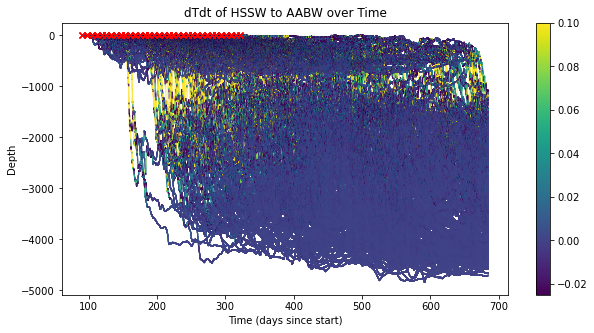

In [9]:
# plot particles with y=depth, x=time, color=temp
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
                 
plt.scatter(x_new,depth_new,marker=".",s=0.05,c=dTdt0,vmin=-0.025,vmax=0.1)
plt.colorbar()
plt.scatter(first_times,first_depths,marker='x',c="red",label="Start Point")
plt.title("dTdt of HSSW to AABW over Time")

# plt.plot(salt_flat,temp_flat,'o',markersize=0.1,zorder=0)
plt.xlabel('Time (days since start)')
plt.ylabel('Depth')

plt.show()

### Show trajectory of AABW particles on map

In [10]:
# for this we need to have the lat/long points

### Show the density maps of AABW only

In [15]:
# select only the aabw indexes
x = (ds.variables['Xgrid'].values[:,aabw_idx])
y = (ds.variables['Ygrid'].values[:,aabw_idx])
#depth = (ds.variables['depth'][-1].values)

# divide the normal grid by 10
xbins = np.r_[0:630:1]
ybins = np.r_[0:560:1]
# index of bins the particles ending in
x_new = np.digitize(x,xbins)
y_new = np.digitize(y,ybins)

In [16]:
import time

In [17]:
x_sing = np.array([])
y_sing = np.array([])
start_time = time.time()
for col in range(x_new.shape[1]):
    if col % 500 == 0:
        print(col,'of',x_new.shape[1],'in',(time.time()-start_time)/60)
    # create a set of datapoints
    thisx = (x_new[:,col])
    thisy = (y_new[:,col])
    
    # create the array of the colum
    arr = np.vstack((thisx,thisy))
    arr = arr.T
    
    # create a set from the array so each coordinate visits each grid square once
    set_coords = list(set(map(tuple,arr)))
    for myset in set_coords:
        x_sing = np.append(x_sing,myset[0])
        y_sing = np.append(y_sing,myset[1])

0 of 349 in 1.52587890625e-06


In [18]:
pts = np.vstack((x_sing,y_sing))
pts = pts.T

# normalize to the total number of particles
counts = list(zip(*np.unique(pts, return_counts = True, axis = 0)))
num_positions = len(counts)
#print(counts)
print(num_positions)

4250


In [19]:
# pop the nan values
counts.pop()

(array([630., 560.]), 349)

In [21]:
mesh = np.zeros((len(xbins),len(ybins)))
num_particles = 349

for ii in counts[:-1]:
    iind = ii[0][0]
    jind = ii[0][1]
    # create the mesh without the scaling by time
    myval = ii[1]/num_particles
    
    # scale by time for one day
    myval = (myval/900)*86400
    
    mesh[int(iind)][int(jind)] = myval
    
    # 
mesh

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
[Xbins, Ybins] = np.meshgrid(ybins,xbins)
print(Xbins.shape)

(630, 560)


In [23]:
# # transform the Ybins and Xbins into lat/long points
lat_values = dg.lat_rho.values
long_values = dg.lon_rho.values
print(lat_values.shape)
lat = np.array([])
long = np.array([])

# # interpolate in latitude
x_shape = np.arange(dg.lat_rho.shape[0])
y_shape = np.arange(dg.lat_rho.shape[1])
# for each row
for i,j in zip(Xbins,Ybins):
    # for each column create the long and lat values
    row_long = np.array([])
    row_lat = np.array([])
    
    for a,b in zip(i,j):
        interp_x = a
        interp_y = b
        # interpolate in longitude
        thislong = long_values[interp_x,interp_y]
        # interpolate in latitude
        thislat = lat_values[interp_x,interp_y]
        
        row_long = np.append(row_long,thislong)
        row_lat = np.append(row_lat,thislat)
    
    if len(lat) == 0:
        lat = np.append(lat,row_lat)
        long = np.append(long,row_long)
    else:
        lat = np.vstack((lat,row_lat))
        long = np.vstack((long,row_long))

(560, 630)


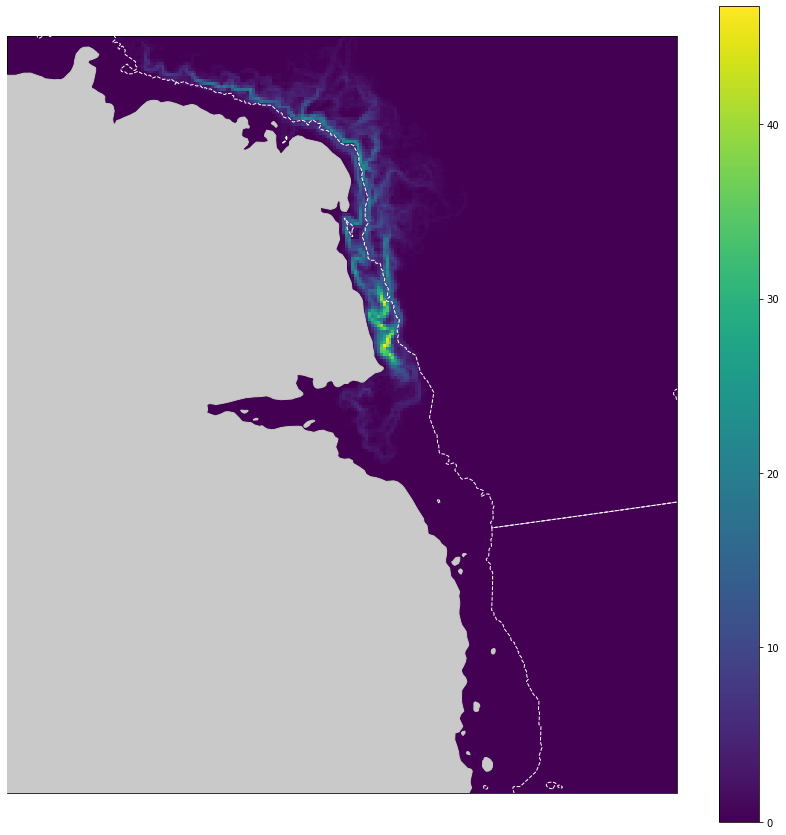

In [33]:
proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1, projection=proj) 
#ds1.temp.isel(ocean_time=1).plot(transform=ccrs.PlateCarree())
#ax.coastlines(facecolor='white',edgecolor='black')
ax.coastlines(zorder=5,facecolor='white',edgecolor='white')

xlimit = np.arange(240,500,1)
ylimit = np.arange(400,630,1)
#plt.pcolormesh(dg.lon_rho[300:560,200:630],dg.lat_rho[300:560,200:630],ds1.temp.isel(xi_rho=slice(200, 630),eta_rho=slice(300,560)),transform=ccrs.PlateCarree())
plt.pcolormesh(long[400:,240:500],lat[400:,240:500],mesh[400:,240:500],transform=ccrs.PlateCarree(),zorder=2)
plt.colorbar()
plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.zice[xlimit,ylimit],levels=[0],zorder=3,linestyles='dashdot', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
#plt.contour(dg.lon_rho[xlimit,ylimit], dg.lat_rho[xlimit,ylimit],ds1.h[xlimit,ylimit],levels=[200,400,600],zorder=5, linestyles='solid', transform=ccrs.PlateCarree(), cmap=plt.cm.binary)
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
#bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, zorder=3, facecolor='none', edgecolor='white', linestyle='dashed', linewidth=1)
ax.add_feature(cfeature.LAND,facecolor='#c9c9c9',zorder=6)
#fig.subplots_adjust(left=100, bottom=10, right=110, top=11, wspace=0, hspace=0)
#fig.colorbar(fig, ax=ax)

plt.savefig('AABW_method2.png')
#myds = ds1.temp[xlimit,ylimit]
#ds1.h.isel(xi_rho=slice(350, 630),eta_rho=slice(300,630)).plot(x="lon_rho", y="lat_rho",transform=ccrs.PlateCarree())